In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pathlib import Path

import random

#from google.colab import drive
#drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
import importlib
try: 
    importlib.reload(data)
    importlib.reload(networks)
    importlib.reload(trainer)
    print("libs reloaded")
except:
    import data 
    import networks 
    import trainer
    import utils
    print("libs imported")

VAE = networks.VAE
TrainerMaskVAE = trainer.TrainerMaskVAE

libs imported


C:\Users\20192024\Anaconda3\envs\capitaselecta\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Mask VAE

In [49]:
WORKING_DIR = Path(r"C:\Users\20192024\OneDrive - TU Eindhoven\Documents\Y4\Q3\Capita Selecta in Medical Image Analysis\Project\Nieuw")
DATA_DIR = WORKING_DIR / "TrainingData"
PROGRESS_DIR_VAE = WORKING_DIR / "progress_vae"
PROGRESS_DIR_VAE.mkdir(parents=True, exist_ok=True)

NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64,64]

# probably too large for masks: (check mnist)
Z_DIM = 256

BATCH_SIZE = 32
N_EPOCHS = 100
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3

#nADAM instead of adam

OPTIMIZER = lambda parameters, lr : torch.optim.Adam(parameters, lr=lr, betas=(0.5,0.999))
#OPTIMIZER = lambda parameters, lr : torch.optim.RMSprop(
#    parameters,
#    lr=lr,
#    alpha=0.9,
#    eps=1e-8,
#    weight_decay=0,
#    momentum=0,
#    centered=False
#)

# loewr epochs increases weights faster
KLD_ANNEALING_EPOCHS = 25
KLD_EPOCHS = 75

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

In [50]:
utils.remove_empty_masks(DATA_DIR)

In [51]:
# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

# load training data and create DataLoader with batching and shuffling
train_set = data.ProstateMRMaskDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = data.ProstateMRMaskDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

transform = transforms.Compose([
     transforms.RandomRotation((-6.,+6.), interpolation=transforms.InterpolationMode.NEAREST),
     transforms.RandomResizedCrop((64,64), scale=(0.8,1.), ratio=(1,1), interpolation=transforms.InterpolationMode.NEAREST, antialias=True)
 ])

train_set.transform = transform
    
train_set.labels = train_set.labels[:,0:1]
valid_set.labels = valid_set.labels[:,0:1]

In [52]:
vae_model = VAE(spade=False).to(device)
optimizer = OPTIMIZER(vae_model.parameters(), lr=LEARNING_RATE)
vae_trainer = TrainerMaskVAE(
    vae_model,
    optimizer,
    KLD_ANNEALING_EPOCHS,
    PROGRESS_DIR_VAE,
    train_loader,
    valid_loader,
    device,
)

In [ ]:
vae_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch #0: Rec_Loss/train = 0.53055, KLD/train = 4.65569 | Rec_Loss/valid = 0.56141, KLD/valid = 7.55367


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch #1: Rec_Loss/train = 0.33961, KLD/train = 4.79202 | Rec_Loss/valid = 0.29159, KLD/valid = 2.45702


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch #2: Rec_Loss/train = 0.30713, KLD/train = 2.80544 | Rec_Loss/valid = 0.24767, KLD/valid = 2.34088


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Epoch #3: Rec_Loss/train = 0.23606, KLD/train = 1.87006 | Rec_Loss/valid = 0.28126, KLD/valid = 1.45415


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Epoch #4: Rec_Loss/train = 0.20380, KLD/train = 1.31242 | Rec_Loss/valid = 0.36504, KLD/valid = 0.74460


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Epoch #5: Rec_Loss/train = 0.17649, KLD/train = 0.79261 | Rec_Loss/valid = 0.19854, KLD/valid = 0.45936


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Epoch #6: Rec_Loss/train = 0.17172, KLD/train = 0.58996 | Rec_Loss/valid = 0.23000, KLD/valid = 0.38623


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Epoch #7: Rec_Loss/train = 0.17182, KLD/train = 0.47502 | Rec_Loss/valid = 0.31118, KLD/valid = 0.24627


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Epoch #8: Rec_Loss/train = 0.17716, KLD/train = 0.34020 | Rec_Loss/valid = 0.17984, KLD/valid = 0.23989


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Epoch #9: Rec_Loss/train = 0.17965, KLD/train = 0.27138 | Rec_Loss/valid = 0.24755, KLD/valid = 0.17717


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Epoch #10: Rec_Loss/train = 0.16234, KLD/train = 0.18276 | Rec_Loss/valid = 0.23734, KLD/valid = 0.12450


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Epoch #11: Rec_Loss/train = 0.17059, KLD/train = 0.14806 | Rec_Loss/valid = 0.24309, KLD/valid = 0.08520


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Epoch #12: Rec_Loss/train = 0.17811, KLD/train = 0.12315 | Rec_Loss/valid = 0.24712, KLD/valid = 0.11296


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Epoch #13: Rec_Loss/train = 0.21877, KLD/train = 0.16189 | Rec_Loss/valid = 0.59004, KLD/valid = 0.16182


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch #14: Rec_Loss/train = 0.20770, KLD/train = 0.12897 | Rec_Loss/valid = 0.25524, KLD/valid = 0.05504


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch #15: Rec_Loss/train = 0.17679, KLD/train = 0.07750 | Rec_Loss/valid = 0.26182, KLD/valid = 0.04853


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch #16: Rec_Loss/train = 0.17480, KLD/train = 0.06943 | Rec_Loss/valid = 0.22836, KLD/valid = 0.05650


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch #17: Rec_Loss/train = 0.17466, KLD/train = 0.06783 | Rec_Loss/valid = 0.28230, KLD/valid = 0.04879


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Epoch #18: Rec_Loss/train = 0.17486, KLD/train = 0.06435 | Rec_Loss/valid = 0.27007, KLD/valid = 0.06532


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch #19: Rec_Loss/train = 0.16812, KLD/train = 0.06479 | Rec_Loss/valid = 0.23873, KLD/valid = 0.05440


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch #20: Rec_Loss/train = 0.16952, KLD/train = 0.06012 | Rec_Loss/valid = 0.26293, KLD/valid = 0.05078


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Epoch #21: Rec_Loss/train = 0.16400, KLD/train = 0.06073 | Rec_Loss/valid = 0.25469, KLD/valid = 0.04776


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch #22: Rec_Loss/train = 0.16147, KLD/train = 0.06282 | Rec_Loss/valid = 0.26740, KLD/valid = 0.05198


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Epoch #23: Rec_Loss/train = 0.16164, KLD/train = 0.06106 | Rec_Loss/valid = 0.21956, KLD/valid = 0.04594


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch #24: Rec_Loss/train = 0.15982, KLD/train = 0.06106 | Rec_Loss/valid = 0.25043, KLD/valid = 0.04605


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch #25: Rec_Loss/train = 0.16432, KLD/train = 0.05854 | Rec_Loss/valid = 0.22059, KLD/valid = 0.05244


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Epoch #26: Rec_Loss/train = 0.15886, KLD/train = 0.06065 | Rec_Loss/valid = 0.22669, KLD/valid = 0.04474


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Epoch #27: Rec_Loss/train = 0.16036, KLD/train = 0.05785 | Rec_Loss/valid = 0.22736, KLD/valid = 0.04682


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Epoch #28: Rec_Loss/train = 0.16043, KLD/train = 0.06055 | Rec_Loss/valid = 0.25291, KLD/valid = 0.04177


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch #29: Rec_Loss/train = 0.15727, KLD/train = 0.05899 | Rec_Loss/valid = 0.23098, KLD/valid = 0.04668


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Epoch #30: Rec_Loss/train = 0.15226, KLD/train = 0.05814 | Rec_Loss/valid = 0.22588, KLD/valid = 0.04091


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Epoch #31: Rec_Loss/train = 0.15431, KLD/train = 0.05748 | Rec_Loss/valid = 0.21686, KLD/valid = 0.04312


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Epoch #32: Rec_Loss/train = 0.15165, KLD/train = 0.05618 | Rec_Loss/valid = 0.21491, KLD/valid = 0.04881


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch #33: Rec_Loss/train = 0.15341, KLD/train = 0.05849 | Rec_Loss/valid = 0.22868, KLD/valid = 0.04812


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch #34: Rec_Loss/train = 0.14933, KLD/train = 0.05855 | Rec_Loss/valid = 0.25715, KLD/valid = 0.04144


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Epoch #35: Rec_Loss/train = 0.15082, KLD/train = 0.05733 | Rec_Loss/valid = 0.21251, KLD/valid = 0.04778


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Epoch #36: Rec_Loss/train = 0.15071, KLD/train = 0.05811 | Rec_Loss/valid = 0.23820, KLD/valid = 0.04613


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Epoch #37: Rec_Loss/train = 0.14372, KLD/train = 0.05736 | Rec_Loss/valid = 0.25445, KLD/valid = 0.04321


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch #38: Rec_Loss/train = 0.14922, KLD/train = 0.05681 | Rec_Loss/valid = 0.21772, KLD/valid = 0.05009


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch #39: Rec_Loss/train = 0.15093, KLD/train = 0.05769 | Rec_Loss/valid = 0.20371, KLD/valid = 0.05557


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Epoch #40: Rec_Loss/train = 0.14235, KLD/train = 0.05917 | Rec_Loss/valid = 0.20141, KLD/valid = 0.04726


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch #41: Rec_Loss/train = 0.14833, KLD/train = 0.05586 | Rec_Loss/valid = 0.21552, KLD/valid = 0.05312


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Epoch #42: Rec_Loss/train = 0.14526, KLD/train = 0.05958 | Rec_Loss/valid = 0.22137, KLD/valid = 0.05365


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Epoch #43: Rec_Loss/train = 0.14014, KLD/train = 0.05819 | Rec_Loss/valid = 0.20170, KLD/valid = 0.04963


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Epoch #44: Rec_Loss/train = 0.13979, KLD/train = 0.05714 | Rec_Loss/valid = 0.23415, KLD/valid = 0.04057


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch #45: Rec_Loss/train = 0.13793, KLD/train = 0.05484 | Rec_Loss/valid = 0.23084, KLD/valid = 0.04132


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Epoch #46: Rec_Loss/train = 0.13660, KLD/train = 0.05440 | Rec_Loss/valid = 0.20738, KLD/valid = 0.03999


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Epoch #47: Rec_Loss/train = 0.13526, KLD/train = 0.05507 | Rec_Loss/valid = 0.21659, KLD/valid = 0.04199


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Epoch #48: Rec_Loss/train = 0.13555, KLD/train = 0.05597 | Rec_Loss/valid = 0.23158, KLD/valid = 0.04164


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch #49: Rec_Loss/train = 0.13739, KLD/train = 0.05573 | Rec_Loss/valid = 0.22453, KLD/valid = 0.04120


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Epoch #50: Rec_Loss/train = 0.13342, KLD/train = 0.05462 | Rec_Loss/valid = 0.19681, KLD/valid = 0.04230


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Epoch #51: Rec_Loss/train = 0.13508, KLD/train = 0.05397 | Rec_Loss/valid = 0.19431, KLD/valid = 0.05026


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Epoch #52: Rec_Loss/train = 0.13533, KLD/train = 0.05787 | Rec_Loss/valid = 0.23314, KLD/valid = 0.04240


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Epoch #53: Rec_Loss/train = 0.12886, KLD/train = 0.05544 | Rec_Loss/valid = 0.21849, KLD/valid = 0.04115


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch #54: Rec_Loss/train = 0.12763, KLD/train = 0.05260 | Rec_Loss/valid = 0.21461, KLD/valid = 0.04441


100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Epoch #55: Rec_Loss/train = 0.12644, KLD/train = 0.05455 | Rec_Loss/valid = 0.19262, KLD/valid = 0.05058


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Epoch #56: Rec_Loss/train = 0.12471, KLD/train = 0.05328 | Rec_Loss/valid = 0.21047, KLD/valid = 0.04397


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch #57: Rec_Loss/train = 0.12450, KLD/train = 0.05404 | Rec_Loss/valid = 0.20224, KLD/valid = 0.05905


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch #58: Rec_Loss/train = 0.12294, KLD/train = 0.05560 | Rec_Loss/valid = 0.21342, KLD/valid = 0.04096


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch #59: Rec_Loss/train = 0.12196, KLD/train = 0.05366 | Rec_Loss/valid = 0.18810, KLD/valid = 0.04188


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch #60: Rec_Loss/train = 0.12152, KLD/train = 0.05218 | Rec_Loss/valid = 0.21455, KLD/valid = 0.04288


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Epoch #61: Rec_Loss/train = 0.11781, KLD/train = 0.05274 | Rec_Loss/valid = 0.19856, KLD/valid = 0.04800


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Epoch #62: Rec_Loss/train = 0.11797, KLD/train = 0.05242 | Rec_Loss/valid = 0.19281, KLD/valid = 0.04466


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch #63: Rec_Loss/train = 0.11683, KLD/train = 0.05243 | Rec_Loss/valid = 0.21497, KLD/valid = 0.04550


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Epoch #64: Rec_Loss/train = 0.11723, KLD/train = 0.05313 | Rec_Loss/valid = 0.21053, KLD/valid = 0.04878


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Epoch #65: Rec_Loss/train = 0.11517, KLD/train = 0.05247 | Rec_Loss/valid = 0.19775, KLD/valid = 0.04593


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Epoch #66: Rec_Loss/train = 0.11348, KLD/train = 0.05109 | Rec_Loss/valid = 0.18872, KLD/valid = 0.03958


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Epoch #67: Rec_Loss/train = 0.11365, KLD/train = 0.05031 | Rec_Loss/valid = 0.18820, KLD/valid = 0.04378


 92%|█████████▏| 22/24 [01:24<00:07,  3.92s/it]

### Plot reconstruction loss

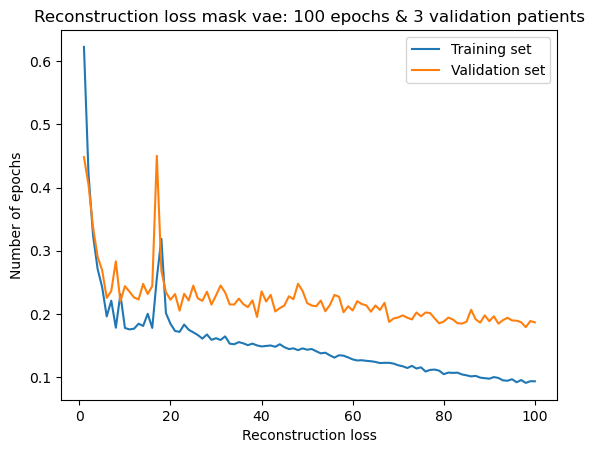

In [39]:
plt.plot(range(1,N_EPOCHS+1), vae_trainer.train_losses[0])
plt.plot(range(1,N_EPOCHS+1), vae_trainer.valid_losses[0])
plt.xlabel('Reconstruction loss')
plt.ylabel('Number of epochs')
plt.title('Reconstruction loss mask vae: {epochs} epochs & {valid} validation patients'.format(epochs=N_EPOCHS, valid=NO_VALIDATION_PATIENTS))
plt.legend(['Training set', 'Validation set'])
plot_name = 'RECON_LOSS'+str(N_EPOCHS) + 'epochs_' + str(NO_VALIDATION_PATIENTS) + '_validpatients.png'
path = PROGRESS_DIR_VAE / plot_name

plt.savefig(path, dpi=200)

### Plot KLD loss

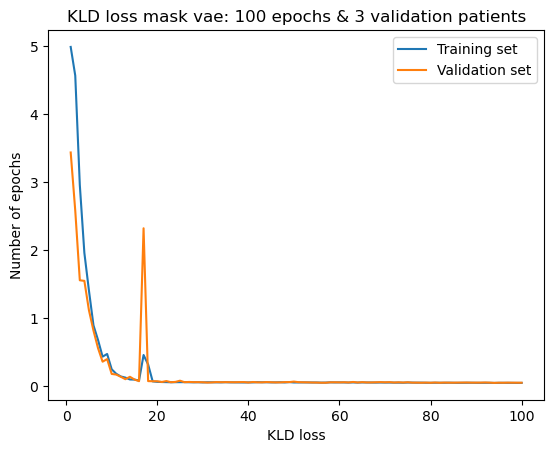

In [40]:
plt.plot(range(1,N_EPOCHS+1), vae_trainer.train_losses[1])
plt.plot(range(1,N_EPOCHS+1), vae_trainer.valid_losses[1])
plt.xlabel('KLD loss')
plt.ylabel('Number of epochs')
plt.title('KLD loss mask vae: {epochs} epochs & {valid} validation patients'.format(epochs=N_EPOCHS, valid=NO_VALIDATION_PATIENTS))
plt.legend(['Training set', 'Validation set'])
plot_name = 'KLD_LOSS'+str(N_EPOCHS) + 'epochs_' + str(NO_VALIDATION_PATIENTS) + '_validpatients.png'
path = PROGRESS_DIR_VAE / plot_name

plt.savefig(path, dpi=200)

### Plot losses together (sum)

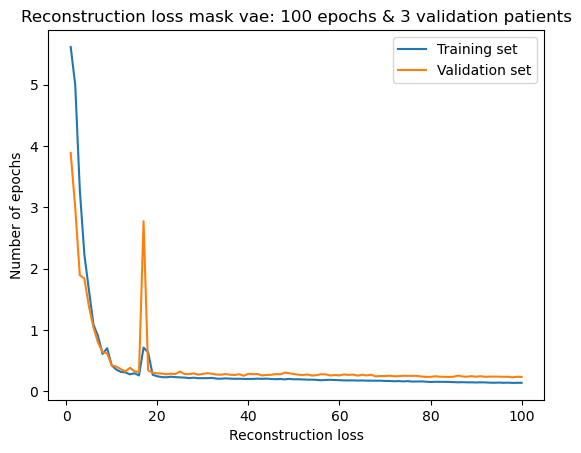

In [41]:
plt.plot(range(1,N_EPOCHS+1), [sum(x) for x in zip(*vae_trainer.train_losses)])
plt.plot(range(1,N_EPOCHS+1), [sum(x) for x in zip(*vae_trainer.valid_losses)])
plt.xlabel('Combined loss')
plt.ylabel('Number of epochs')
plt.title('Combined loss mask vae: {epochs} epochs & {valid} validation patients'.format(epochs=N_EPOCHS, valid=NO_VALIDATION_PATIENTS))
plt.legend(['Training set', 'Validation set'])
plot_name = 'COMBINED_LOSS'+str(N_EPOCHS) + 'epochs_' + str(NO_VALIDATION_PATIENTS) + '_validpatients.png'
path = PROGRESS_DIR_VAE / plot_name

plt.savefig(path, dpi=200)

### Save losses in .txt files

In [42]:
TRAIN_DIR = PROGRESS_DIR_VAE / 'training'
VALID_DIR = PROGRESS_DIR_VAE / 'validation'
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VALID_DIR.mkdir(parents=True, exist_ok=True)

filename = str(N_EPOCHS) + 'epochs_' + str(NO_VALIDATION_PATIENTS) + '_validpatients.txt' 
file_train = open(TRAIN_DIR / filename, 'w')
file_valid = open(VALID_DIR / filename,'w')

for i, j in zip(vae_trainer.train_losses, vae_trainer.valid_losses):
    file_train.write("{loss}\n".format(loss=i))
    file_valid.write("{loss}\n".format(loss=j))

file_train.close()
file_valid.close()


Check txt files here, if not good enough, try code below